In [1]:
import numpy as np
from scipy.stats import multivariate_normal,percentileofscore
import scipy as sp
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import itertools
import math
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
chr_start=97
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
#Restricts x to what the agents can see 
def restrictXList(x_list,index):
    
    def splitList(S, step):
        pairs=np.transpose([S[i::step] for i in range(step)])
        pairs=np.add(pairs[1::2],pairs[::2])/2
        return np.append(pairs,pairs,axis=1).flatten()
    
    new_x_list=np.zeros((2,2**ns))
    for j in range(2):
        new_x_list[j]=splitList(x_list[j],2**index)

    return new_x_list

In [3]:
N    =2000  #NUMBER OF AGENTS
n    =250 #NUMBER OF STEPS
dt   =1
steps=int(n/dt)
w=10
W=w+1
ns   =4  #SIZE OF EVENT SPACE
pxor=.7
p_xor_arr=np.random.uniform(0.5,.9999,size=int(2**ns))
#p0,p1
# p_xor_arr=[.99999,.000001,.999999,.999999,.999999,.999999,.999999,.999999,.999999,.999999,.999999,.999999,.999999,.999999,.999999,.999999]
# p_xor_arr=[.5 for ÷i in range(int(2**ns))]


X=np.linspace(.01,.99,100000)
corr =0
eta  =.51
sig_e=.01
r0   =1
sig_r=.00001*r0
K1=20

xor_index=0
p_marg_s=.5
totalinfo=[]

l=2
l1=None
l0=None
ll=None

#For manipulating the binary values of the tree and marginalizing p
ind_arr=np.linspace(0,len(p_xor_arr)-1,len(p_xor_arr),dtype=int)
bin_sel={} #Selects which index a signal applies a p or q to
bin_arr =np.array([2**i for i in range(ns)])
xor_sltr = np.array([bin(i).count("1")%2 for i in ind_arr])
listed_signals=[i for i in range(ns)]

In [4]:
#how to generalize the XOR gate
def xorGate(inputs,p_xor):
    global xor_index
    #RANDOM GENERATED PXOR
    p_xor=p_xor_arr[xor_index]
    #DETERMINISTED PXOR otherwise
    
    xor_index+=1

    if np.sum(inputs)%2==0:
        return [p_xor,1-p_xor]
    else:
        return [1-p_xor,p_xor]

def itMarg(es,ss_post,N,depth):
    if N<depth:
        return [itMarg(s,s_post,depth,N+1) for s in es]
    else:
        return np.multiply(es,ss_post)

Step 1: Generate Environment and Signals

In [5]:
def iterateMarginals(ns,depth,ps_marg,index,pxor,tp):
    if depth<ns-1:
        return np.array([iterateMarginals(ns,depth+1,pmarg,np.append(index,i),pxor,tp)\
                for pmarg,i in zip(ps_marg,range(2))])
    else:
        if tp=="joint":
            return np.multiply(xorGate(index,pxor),ps_marg)
        if tp=="cond":
            return xorGate(index,pxor)

def genPXOR(ns):
    global xor_index
    xor_index=0
    
    ps=[p_marg_s,1-p_marg_s]
    
    #For generating the eigensum operator 
    chr_arr=[chr(chr_start+i) for i in range(ns)]
    einsum_op=','.join(chr_arr)+'->'+''.join(chr_arr)   
    
    #p(e_i) marginal product matrix. p(e_i,e_j,e_k)=pe_marg[i,j,k]
    s_joint=np.einsum(einsum_op,*[ps for i in range(ns)]) 
#     print("Shape of s joint:",np.shape(s_joint))
    #Conditional distribution of the marginal and the o distribution. Reversing order for o first
    e_cond_s = np.transpose(\
                            np.array([iterateMarginals(ns,0,pmarg,[i],pxor,"cond") for pmarg,i in zip(s_joint,range(len(ps)))]),\
                            tuple([ns-i for i in range(ns+1)]))
#     print("Shape of e|s:",np.shape(s_joint))
    #Joint distribution of the marginal and the o distribution by performing p(o|e_i)p(e_i)
    xor_index=0
    e_joint_s = np.transpose(\
                            np.array([iterateMarginals(ns,0,pmarg,[i],pxor,"joint") for pmarg,i in zip(s_joint,range(len(ps)))]),\
                            tuple([ns-i for i in range(ns+1)]))

    s_joint = np.transpose(s_joint,tuple([ns-i-1 for i in range(ns)]))
    
    return p_xor_arr,s_joint,e_cond_s,e_joint_s,s_joint

Step 2: Generate agent $x$ values and assign them a signal

In [6]:
def genJointGrowthResourceDistrib(corr,eta_bar,r_bar,sigma_eta,sigma_r,N):
    means = [eta_bar,r_bar]  
    stds = [sigma_eta, sigma_r]
    covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
            [stds[0]*stds[1]*corr,           stds[1]**2]] 
    m = np.random.multivariate_normal(means, covs, N).T
#     return np.exp(2*m[0]),np.exp(2*m[1])
    r_i=np.reshape(m[1],(N,1))
    return m[0],np.exp(r_i)

def permuteIndices(p_arr,p2,p1=0):
    
    #Swapping given bits of a number
    def swapBits(n, p1, p2):

        if ((n & (1 << p1)) >> p1) ^ ((n & (1 << p2)) >> p2):
            n ^= bit
        return n
 
    
    #Gives the permuation of the indices upon swapping layers 0 and i
    bit=1<<p1|1<<p2
    perm_order = [i^bit if (((i & (1 << p1)) >> p1) ^ ((i & (1 << p2)) >> p2)) else i for i in ind_arr  ]
    perm = [p_arr[j] for j in perm_order]
    
    #Determining which indices of the sum are assigned a p or q
    #Counts 1s in binary after first place. place counts%2 
    # abs(counts-p) places p where binary sums to even, q where sums to odd
    counts=[(bin(j)[:-1].count("1"))%2 for j in ind_arr]
    perm = np.absolute(np.subtract(perm,counts))
    #odds go to p1',evens p0'
    p0=np.mean(perm[::2]);p1=np.mean(perm[1::2])
    return p0,p1
    
    
def genXs(Gs,counts,l,p_xor_arr):
    X=np.linspace(.01,.8,100000)
    ps=[]
    x0=[]
    x1=[]
    for i in range(ns):
        if not counts[i+1]-counts[i]:
            print("Skipping",i)
            continue
        #Permutes the order of p_i to swap the ith level of the tree with the 0th 
        #Computes p0,p1 for agent i
        p0,p1=permuteIndices(p_xor_arr,i)
        print("For signal",i)
        print("For params",p0,p1)
        global l0;global l1; global ll
        l0=1/(.5*(p0+1-p1))
        l1=1/(.5*(p1+1-p0))
        
        ll=[l0,l1]
        print("LL",ll)
        print("P",p0,p1)

        #Each p of each s_i has a unique value, so each x for each 
        g0=p0*np.log(X*l0)+(1-p0)*np.log(l0*(1-X))
        g1=p1*np.log(X*l1)+(1-p1)*np.log(l1*(1-X))
                
        #Searches for index of x corresponding to growth rate g0 closest to G in range of Gs defined
        # by the number of agents with that signal (stored in counts)
        xs0=[np.where(g0==min(g0,key=lambda x:abs(x-G))) for G in Gs[counts[i]:counts[i+1]]]
        xs1=[np.where(g1==min(g1,key=lambda x:abs(x-G))) for G in Gs[counts[i]:counts[i+1]]]
        
        x0+=[X[xx][0] for xx in xs0]
        x1+=[X[xx][0] for xx in xs1]
        print("With approximate growth rates:",.5*(np.amax(g0)+np.amax(g1)),"\n\n")
        ps+=[[p0,p1] for xx in xs0]
    
    return np.transpose([x0,x1]),ps

Step 3: Arrange agents into lists of their collectives. Initialize to individuals

In [7]:
ONES=np.ones(steps)


def setGroups(agents,sized=False):
    keys=list(agents.keys());#np.random.shuffle(keys)
    groups = [[] for i in range(N)]
    if not sized:
        for a,i in zip(keys,range(N)): groups[i] = [a] 
    else:
        
        #Ascending group size
#         i=1;j=1
#         while j-i<N:
#             groups[i]=[a for a in keys[j-i:j]]
#             i+=1; j+=i

        #Constant group size
#         i=ns;j=ns;k=0
#         while j-i<N:
#             groups[k]=[a for a in keys[j-i:j]]
#             j+=i;k+=1

        #Demonstration group size
        const=int(N/(4*ns))
        k=1;m=1;
        for i in range(2*ns):
            j=0
            while j<const:
                groups[int(i*const+j)]=[a for a in keys[m-k:m]]
                m+=k;
                j+=1
            m+=k
            k+=i
                
                
    print("GROUPS:",groups)
    return groups

def addAgent(groups,groupID,agents,a):
    
    groups[groupID]['a'].append(a)
    groups[groupID]['s'][agents[a]['s']]+=1
    groups[groupID]['s_list']=list(omit_by(groups[groupID]['s']).keys())
    
    return groups
                         
def removeAgent(groups,groupID,agents,a):
    
    groups[groupID]['a'].remove(a)
    groups[groupID]['s'][agents[a]['s']]-=1
    groups[groupID]['s_list']=list(omit_by(groups[groupID]['s'])).keys()
    
    return groups

    
def setSCount(IDlist,agents):
    s_count={i:0 for i in range(ns)}
    for ID in IDlist:
        s_count[agents[ID]['s']] +=1
    return s_count

def omit_by(dct, predicate=lambda x: x==0):
    return {k: v for k, v in dct.items() if not predicate(v)}

#Generate Individuals
def genAgents(x_list,s_list,p_list,order=2):
    L_matrix=np.full((order,order),1/(order**2))
    agents={}
    agentsID = [i for i in range(N)]

#     for a,x,s,p in zip(agentsID,x_list,np.sort(s_list),p_list):
    for a,x,s,p in zip(agentsID,x_list,s_list,p_list):
        likelihood=np.array([[[x[0],1-x[0]],[1-x[1],x[1]]] for i in range(steps)])
        r_pseudocount=np.divide(likelihood[0],np.amin(likelihood[0][0]))
       
        agents[a]={'i':a,\
                   'x':x,\
                   's':s,\
                   'gamma':.5*(p[0]*np.log(x[0]*l0)+(1-p[0])*np.log((1-x[0])*l1)\
                               +p[1]*np.log(x[1]*l1)+(1-p[1])*np.log((1-x[1])*l0)),\
                   'p':likelihood,\
                   'h':r_pseudocount,\
                   'B':x/(1-x)+1,\
                   'k':K1*ONES,\
                   'g':w*ONES,\
                   'rs':r_pseudocount*np.ones((steps,2,2))
                  }
    for s in np.unique(s_list):
        bin_sel[s]=np.array([int(format(n, '#032b')[2:][-1-s]) for n in range(2**ns)])
        
    return agents

#Generate Groups
def genGroups(groupsList,agents,order=2):

    groups={}
    groupsID = [i for i in range(N)]
    g_x = np.zeros((2,2**ns))
        
    for ID,g in zip(groupsID,groupsList):
        if len(g)>0:
            for gg in g:
                agents[gg]['i']=ID
            sc=setSCount(g,agents) #Sets the number of agents with each signal value s
            xm=setXMatrix(g,g_x,agents) #Sets the posterior for the collective 
            likelihood=np.array([xm for i in range(steps)])
            r_pseudocount=np.divide(likelihood[0],np.amin(likelihood[0]))

            XARR=[xm for i in range(steps)]
            #a:agent list, s:signal list, x:initial x list, b:betting matrix, p:likelihood, 
            groups[ID]={'i':ID,\
                        'a':g,\
                        's':sc,\
                        'x':XARR,\
                        'b':np.transpose(setBetMatrix(sc,likelihood[0])),\
                        'p':likelihood,\
                        'h':r_pseudocount,\
                        'B':np.amax(np.array([(xm[1]/xm[0])+1,(xm[0]/xm[1])+1])),\
                        'k':K1*ONES,\
                        'rate':w*ONES,\
                        'rs':[r_pseudocount],\
                        'c': np.array([0,1,1])*1/(ns)
                      }
            groups[ID]['s_list']=list(omit_by(groups[ID]['s']).keys())
            groups[ID]['s_len']=len(groups[ID]['s_list'])
            groups[ID]['c']*=len(groups[ID]['s_list'])

    return groups,agents

def setXMatrix(groupsList,g_x,ags):
    for a in groupsList:
        
            #USE BINOMIAL SELECTOR TO ASSIGN P OR Q TO G_X
            #Assigns p0 or 1-p1 to 0  or p1 and 1-p0 to 1
            mask=[[np.absolute(j-np.absolute(bin_sel[ags[a]['s']][i]-ags[a]['x'][bin_sel[ags[a]['s']][i]]))\
                   for i in range(2**ns)] for j in range(2)]
            
            g_x=np.add(g_x,mask)
    return g_x/len(groupsList) if len(groupsList)>0 else np.subtract(g_x,g_x)



def marginalizeXList(x_list,index):
    
    def list_slice(S, step):
        return np.transpose([S[i::step] for i in range(step)])
    
    new_x_list=np.zeros((2,int(len(x_list[0])/2)))
    for j in range(2):
        x=list_slice(x_list[j],2**index) #FLIP BECAUSE 0,2^0 at end of list
        new_x_list[j]=np.add(x[1::2],x[::2]).flatten()/2

    return new_x_list

#Restricts x to what the agents can see 
def averageOverOmitted(x_list,index):
    
    def splitList(S, step):
        pairs=np.transpose([S[i::step] for i in range(step)])
        pairs=np.add(pairs[1::2],pairs[::2])/2
        return np.append(pairs,pairs,axis=1).flatten()
    
    new_x_list=np.zeros((2,2**ns))
    for j in range(2):
        new_x_list[j]=splitList(x_list[j],2**index)

    return new_x_list

#POTENTIALLY NEEDS TO UNDO FLIP IN CASE WRONG ELEMENTS ARE BEING MARGINALIZED 
def setBetMatrix(s_count,x_matrix):

    for s,i in zip(np.flip(range(ns)),np.flip(list(s_count.values()))):
        if i==0:
            x_matrix = marginalizeXList(x_matrix,s)

    return x_matrix

Binary arrays are arranged $[p_0,p_1,....]$ so flip before converting to binary

Step 4: Generate samples from environment. We've decided to keep signals uniform and conditionally independent. For now, we can just sample $n*N$ samples and assign them to agents. In this first implementation, agents will live in the same environment

In [8]:
outcomes=[0,1]
#To keep this computationally efficient, we will oversample at the beginning of the simulation, and not worry about sampling for unique combination of agent signals
#ie for N agents, we will produce ns*n samples. Each group (number of groups bounded above by N), gets a unique ns length string of signals that is then used to compute
#an event. First group gets signal set 1, second singal set 2 and so on. This way we can avoid cases where two agents with the same signal sample different values. This
#also allows us to sample the E distribution up top, and avoid the cost of sampling for unique combinations of each group. Sacrificing memory for complexity, which is NBD 
def genSignalsEvents(e_cond_s):
    
    #Generate signals
    signals = np.random.randint(low=0,high=2,size=(n,N,W,ns))
    #Unique symbols, sorted w/ counts
    unique_samps,counts = np.unique(signals.reshape(n*N*W,ns),axis=0,return_counts=True)
    unique_samps = unique_samps.tolist()
    unique_samps.sort()
    combined = {str(u):c for u,c in zip(unique_samps,counts)}

    #Generates "counts" events for every unique signal string, Inserts in "combined" dict indexed by string value
    for sign,c in zip(unique_samps,counts):
        combined[str(sign)]=stats.rv_discrete(name='received', values=([0,1], \
                                [e_cond_s[tuple(np.concatenate(([0],sign)))],e_cond_s[tuple(np.concatenate(([1],sign)))]]\
                                                            )).rvs(size=c).tolist()
    
    #Adds place to every every signal list to give data format[{signal},event]
    signals=np.insert(signals, ns, 0, axis=3)
     
    for j in range(N):
        for i in range(n):
            for k in range(W):
                signals[i,j,k,ns]=combined[str(signals[i,j,k,:ns].tolist())].pop()
    #INSERT TESTING CODE 1A TO ENSURE SAMPLING WORKS
    
    #returned signal list has format (nxNxns+1) where the first ns elements are s and last element is e

    return signals        

Step 5: Have agents gamble on events

In [9]:
def countSigs(s):
    s1=np.linspace(0,ns-1,ns)
    idx = np.searchsorted(s1,s)
    idx[idx==len(s1)] = 0
    mask = s1[idx]==s
    bc=np.bincount(idx[mask])
    return s1,np.pad(bc,(0,ns-len(bc)))

def simulateGamble():
    global p_xor_arr
    resetNs(2)
    
    #Generate Population data
    Gs,r_i=genJointGrowthResourceDistrib(corr,eta,r0,sig_e,sig_r,N)
    resources=np.concatenate((r_i,np.zeros(shape=(N,steps-1))),axis=1) #Resource array

    #Create agents
    p_xor_arr,s_joint,e_cond_s,e_joint_s,s_joint=genPXOR(ns)
    
    
#     s_list=np.random.randint(low=0, high=ns, size=N,dtype=int) #signal list
    
    s_list=np.random.randint(low=0, high=ns, size=N,dtype=int) #Fix submaximal cooperation
    
    s_vals, s_counts = countSigs(s_list)
    s_counts = np.cumsum(np.insert(s_counts,0,0))
#     a_list = sorted(np.transpose([Gs,s_list]), key=lambda x: x[1]) #agent list
    x_list,ps=genXs(Gs,s_counts,l,p_xor_arr)

    agents=genAgents(x_list,s_list,ps)
    
    #Group Agents
    groupsList = setGroups(agents,COOP) #The bool determines whether groups are uniform (false) or stratified (false)
    groups,agents = genGroups(groupsList,agents)
    
    #Generate events
    events = genSignalsEvents(e_cond_s)

    return simulateBetsWLearning(agents,groups,2,events,resources)
    
#     resources=simulateBetsWLearning(agents,groups,2,events,resources)

#     resources=simulateBets(agents,groups,2,events,resources)

To Do: Compute expression for growth rate for the individual as a function of the environmental parameters and the agent's parameter 

By definition, the information of a group must be unique to that group (embedded in the collective?) Agents individually arent capable of conditional model by this construction. Or, they could be capable of conditional knowledge, but are only capable of interpreting single signals, requiring collaboration. The alternative to this are agents that have individual models applied in parallel, that without some additional mechanism are not capable of leveraging the conditional structure of the environmental synergy. 

I think the solution is to give each group its own model, and when a new agent joins the group, they contribute their model. When agents leave groups, they can take their original model I suppose. 

But what if two agents have conflicting models? Averaging would only "average out" synergy if one agent has a unsynergistic model

In [10]:
#Groups will make initial bets by averaging priors across agents within a given signals.
#The collective will encode information in the collective prior, so that synergy is only a feature of the group
#When agents leave, they take information about their prior with them, but not synergy
#If no agents of a signal are present, the synergy their signal provides becomes unavailable
#When agents join a collective, they make available synergy for their signal.
def makeBets(agents,groups,e_set):
    bets=np.zeros((N,W,2))
    for group,outcomes,i in zip(groups.values(),e_set,range(N)):
        if not len(group['a']):
            continue
        for o,j in zip(outcomes,range(W)):
            #Selects only the signals that the agents can see
            #Indexes the bet array by summing over the product of
            #LHS: The representation of the signal in the group-reduced form (ie agent sigs 0,2 reduce 101 to 11) as binary (index 3)
            #RHS: The subsection binary array of length number of signals (ie 2 elements is [1,2])
            ind=np.sum(np.array(o[:-1])[np.sort(group['s_list'])]*bin_arr[:len(group['s_list'])])
            bets[i][j]=group['b'][ind]
    return bets

def simulateBetsWLearning(agents,groups,payouts,events,res):
    i=0
    pc=[]
    pcc=[]

    def learnGroupsDirichletMultinom(groups,agents,outcomes,t):

        if learn:
            global GN_E
            global GN_S
            global GN_ES
            
            #COUNTING SELECTIONS
            for o_set,i,grp in zip(outcomes,range(N),groups.values()):
                if len(grp['a']):
                    
                    g=int(grp['rate'][t])
                    wt=grp['k'][t]
                    c=dt/wt

                    #Updates the counts in the groups
                    for o in o_set[:g]:
                        curr_ind=np.sum(np.multiply(bin_arr,o[:-1]))
                        GN_S[i][curr_ind] +=c
                        GN_E[i][o[-1]]    +=c
                        GN_ES[i][o[-1]][curr_ind]+=c
                        
                        for agID in grp['a']:
                            s=agents[agID]['s']
                            N_S[agID][o[s]]+=c
                            N_E[agID][o[-1]]+=c
                            N_ES[agID][o[-1]][o[s]]+=c

            #UPDATING POSTERIORS
            for (GID,grp),GN_Ei,GN_ESi,GN_Si in zip(groups.items(),GN_E,GN_ES,GN_S):
                if len(grp['a']):
                    update=np.divide(grp['h']+GN_ESi,\
                                      GN_Si+grp['B'])*np.transpose([1+np.array(GN_Ei)])

                    omitted = list(set(listed_signals) - set(grp['s_list']))
                    for o in omitted:
                        update=averageOverOmitted(update,o)
                    
                    #Learning
                    groups[GID]['p'][t]=np.divide(update,[np.sum(update,axis=0)])
                    groups[GID]['b']=np.transpose(setBetMatrix(groups[GID]['s'],groups[GID]['p'][t]))
                    
                    for agID in grp['a']:

                        update=np.divide(agents[agID]['h']+N_ES[agID],\
                                      N_S[agID]+agents[agID]['B'])*(1+N_E[agID])
                        agents[agID]['p'][t]=np.divide(update,np.array([np.sum(update,axis=0)]).T)
                        
        return groups,agents
    
    for t,outcomes in zip(range(1,steps),events):
        bets=makeBets(agents,groups,outcomes)
        #gmeaning the set of outcomes the agent observes
        group_payout= [sp.stats.gmean([ll[o[-1]]*b[o[-1]] for b,o in zip(bet,e)])  for bet,e in zip(bets,outcomes)]

#         pc.append(outcomes[0][-1])
#         pcc.append(np.sum(np.multiply([outcomes[0][1],outcomes[0][-1]],[1,2])))
        #Basic Kelly Update
        payout = [group_payout[agents[i]['i']] for i in agents.keys()]
        
        res.T[t]=res.T[t-1]*payout
        groups,agents=learnGroupsDirichletMultinom(groups,agents,outcomes,t)

    GS=[]
    

    
    ##TEST 2A
    return groups,agents,res
    
def resetNs(order):
    global N_E
    N_E=[np.zeros(order) for i in range(N)]
    global N_S
    N_S=[np.zeros(order) for i in range(N)]
    global N_ES
    N_ES=[np.zeros((order,order)) for i in range(N)] 
    global GN_E
    GN_E=[np.zeros(2) for i in range(N)]
    global GN_S
    GN_S=[np.zeros(int(2**ns)) for i in range(N)]
    global GN_ES
    GN_ES=[np.zeros((2,int(2**ns))) for i in range(N)] 

N_E=[]
N_S=[]
N_ES=[]
GN_E=[]
GN_S=[]
GN_ES=[]

In [11]:
def theoryR(r0,g):
    np.cumprod

def computeGDKL(groups,agents,res,thr):

    INFO=[]
    thrINFO=[]

    info=np.zeros(steps) #FOR RETURNING INFORMATION
    thr_info=np.zeros(steps) #FOR RETURNING THEORY INFORMATION
    
    for g,th in zip(groups.values(),thr):
        info*=0;thr_info*=0
        for t in range(steps):
            info[t],thr_info[t]=computeDKL(g['p'][t],g['s'],len(g['s_list']),th[t])
    
        INFO.append(np.copy(info))
        thrINFO.append(np.copy(thr_info))

    G_INFO=[]
    G_thrINFO=[]
    SCountList=[]
    SList=[]
    #ASSIGNS GROUP TRAJ, DKL, and number of SIGNALS TO SINGLE ARRAY
    for g,info,thr_info in zip(groups.values(),INFO,thrINFO):
        if not COOP:
            r=res[g['a'][0]]
            plt.plot(np.log(r),color='k',alpha=.5)
        else:
            r=None
            for a,iii in zip(g['a'],range(len(g['a']))):
                r=res[a]
                break
            r_thr=r[0]*np.cumprod(np.exp(thr_info))
            G_INFO.append([info,np.log(r)])
            G_thrINFO.append([thr_info,np.log(r_thr)])
            SCountList.append(len(g['s_list']))
            SList.append(g['s_list'])
            

    G_INFO    = [gd for _,gd in sorted(zip(SCountList,G_INFO), key=lambda pair: pair[0],reverse=True)]
    G_thrINFO = [gd for _,gd in sorted(zip(SCountList,G_thrINFO), key=lambda pair: pair[0],reverse=True)]
    SList     = [sl for _,sl in sorted(zip(SCountList,SList), key=lambda pair: pair[0],reverse=True)]
    SCList    = [sc for sc in sorted(SCountList, reverse=True)]

    return G_INFO,G_thrINFO,SCList,SList

#Receives the list of the group's x array at a time, the list of signals the group has, and the theoretical x values (temporal-meaned) they should have at that ime 
def computeDKL(x_arr,s_count,k,thr):

    global p_xor
    
    #Expands the array to include both marginals of E
    x_thr=np.array([thr,np.subtract(1,thr)])
    p_temp=np.array([[(1-p)*int(j!=i)+p*int(j==i) for j,p in zip(xor_sltr,p_xor_arr)] for i in range(2)])
  
    #Marginalizes p matrix
    for s,i in zip(np.flip(range(ns)),np.flip(list(s_count.values()))):
        if i==0:
            x_arr = marginalizeXList(x_arr,s)
            x_thr = marginalizeXList(x_thr,s)
            p_temp=marginalizeXList(p_temp,s)

    info = []
    
    xse_joint=x_arr/(2**k)
    pse_joint=p_temp/(2**k)
    xth_joint=x_thr/(2**k)

    xs =np.sum(xse_joint,axis=1)
    ps =np.sum(pse_joint,axis=1)
    xths=np.sum(xth_joint,axis=1)

    
#     print("PJ:",pse_joint)
#     print("PCOND:",p_arr)
#     print("PMARG:",ps)
    E_DKL= np.sum([psj*(np.log(x/pm)) for psj,x,pm in zip(pse_joint,x_arr,ps)])
    E_thr= np.sum([psj*(np.log(x/pm)) for psj,x,pm in zip(pse_joint,x_thr,ps)])
    return E_DKL, E_thr

In [12]:
pcolors={'[0.   0.25 0.25]': [0.  , 0, 0.0],'[0.  0.5 0.5]': [0. ,0, 0.333],'[0.   0.75 0.75]': [0.  , .125, 0.666],'[0. 1. 1.]': [0.,.25, 1.]}

In [13]:
#ns=4
p_xor_arr=np.array([0.14728741, 0.72355019, 0.46451306, 0.70678105, 0.46583055,
       0.35943405, 0.97082988, 0.37095391, 0.87884519, 0.70941512,
       0.79726053, 0.63799689, 0.43272064, 0.22389835, 0.40441803,
       0.15949486])
p_arr = np.array([[(1-p)*int(j!=i)+p*int(j==i) for j,p in zip(xor_sltr,p_xor_arr)] for i in range(2)])
COOP=True
learn=True
groupsMAX1,agentsMAX1,resMAX1=simulateGamble()

For signal 0
For params 0.5168114537499999 0.5026592825
LL [1.9720906356044052, 2.0287106606867393]
P 0.5168114537499999 0.5026592825
With approximate growth rates: 0.0003899020631952235 


For signal 1
For params 0.41959161749999996 0.40543944625
LL [1.9720906356044048, 2.0287106606867393]
P 0.41959161749999996 0.40543944625
With approximate growth rates: 0.01558959935160975 


For signal 2
For params 0.4569798475 0.44282767624999997
LL [1.9720906356044048, 2.0287106606867398]
P 0.4569798475 0.44282767624999997
With approximate growth rates: 0.005229010726369714 


For signal 3
For params 0.519935585 0.50578341375
LL [1.9720906356044048, 2.0287106606867393]
P 0.519935585 0.50578341375
With approximate growth rates: 0.0005311335361381153 


GROUPS: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41]

In [14]:
def propagateXValues(groups):
    NN=len(groups)
    timedom=np.linspace(np.zeros((NN,2**ns)),np.ones((NN,2**ns))*n-1,n)
    signals=[]
    time_xs=[]
    es=[]
    for key,group in groups.items():
        signals.append(group['s_list'])
        es.append(K1*group['B']*ONES*2)
        time_xs.append(np.multiply(np.ones((steps,2**ns)),group['x'][0][0]))
    x0s=np.transpose(time_xs,(1,0,2))[0]
    lbd=np.transpose(np.divide(np.transpose(timedom,(2,1,0)),es),(2,1,0))
    xbart=(p_arr[0]*lbd+x0s)/(1+lbd)

    return signals,np.transpose(xbart,(1,0,2))

In [15]:
sigs,thrTraj=propagateXValues(groupsMAX1)
info,infoTHR,SCLMAX1,SLMAX1=computeGDKL(groupsMAX1,agentsMAX1,resMAX1,thrTraj)

In [16]:
import matplotlib
plt.rcParams["figure.figsize"] = (6,5)
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')


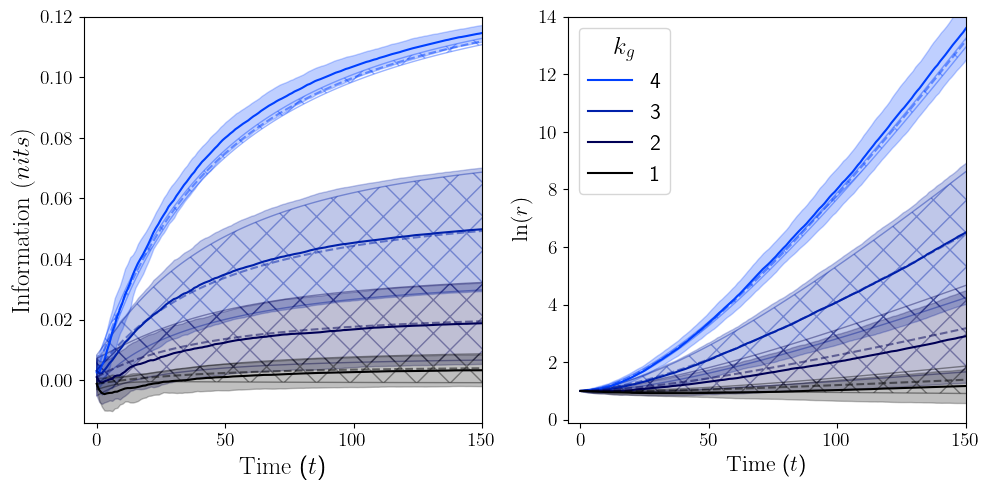

In [22]:
plotFig1(info,infoTHR,SCLMAX1,SLMAX1,"a4configMAX1")

In [21]:
def plotFig1(G_DKL,G_THR,Counts,Sigs,fname):    
    s_indices=[]
    plt.rcParams["figure.figsize"] = (10,5)
    b=[] #Number of signals present
      #Finds the index boundaries of groups with i signals
    for i in np.flip(range(1,ns+1)):
        for aa, j  in zip(Counts,range(len(Counts))):
            if i>aa:
                b.append(j)
                break
    b.append(len(G_DKL))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    timedom=np.linspace(0,n,n)
    
    a=G_DKL
    a_thr=G_THR
    b0=0

    lbl=[4,3,2,1]
    for bb,cc,l,sc,s in zip(b,np.flip(list(pcolors.values()),axis=0),lbl,Counts,Sigs):
        #Takes the mean of all agents with certain number of unique signals (between b0 and bb)

        a_mean=np.mean(a[b0:bb],axis=0)
        a_mean_thr=np.mean(a_thr[b0:bb],axis=0)
        a_std=np.var(a[b0:bb],axis=0)
        a_std_thr=np.var(a_thr[b0:bb],axis=0)
        
        ax1.fill_between(timedom,a_mean[0]-np.sqrt(a_std[0])*.95, a_mean[0]+np.sqrt(a_std[0])*.95,alpha=.25,color=cc)
        ax1.fill_between(timedom,a_mean_thr[0]-np.sqrt(a_std_thr[0])*.95, a_mean_thr[0]+np.sqrt(a_std_thr[0])*.95,alpha=.4,color=cc,hatch="X",facecolor="none")

        ax1.plot(a_mean[0],color=cc)
        ax1.plot(a_mean_thr[0],color=cc,alpha=.5,linestyle='dashed')
        
        ax2.fill_between(timedom,a_mean[1]-np.sqrt(a_std[1])*.95, a_mean[1]+np.sqrt(a_std[1])*.95,alpha=.25,color=cc)
        ax2.fill_between(timedom,a_mean_thr[1]-np.sqrt(a_std_thr[1])*.95, a_mean_thr[1]+np.sqrt(a_std_thr[1])*.95,alpha=.4,color=cc,hatch="X",facecolor="none")

        ax2.plot(a_mean_thr[1],color=cc,alpha=.5,linestyle='dashed')
        ax2.plot(a_mean[1],color=cc,label=str(l))

        b0=bb
    plt.legend(fontsize=16,title=r"$k_g$",title_fontsize=18)
    ax1.set_ylabel(r"$\textrm{Information}$ $(nits)$",fontsize=18)
    ax1.set_xlabel(r"$\textrm{Time}$ ($t$)",fontsize=18)

    ax2.set_xlabel(r"$\textrm{Time}$ ($t$)",fontsize=16)
    ax2.set_ylabel(r"$\textrm{ln}$$(r)$",fontsize=16)
    ax2.set_ylim(top=14,bottom=-.1)
    ax1.set_ylim(top=.12,bottom=-.014)
    ax1.set_xlim(left=-5,right=150)
    ax2.set_xlim(left=-5,right=150)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='both', which='minor', labelsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='minor', labelsize=14)
#     ax1.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
    
    plt.tight_layout()
    plt.savefig("Synergy"+fname+".pdf")
    plt.show()

def plotFig2(G_DKL,fname):
    plt.rcParams["figure.figsize"] = (10,5)
    s_indices=[]
    b=[]
    for i in np.flip(range(1,ns+1)):
        for aa, j in zip(G_DKL,range(len(G_DKL))):
            if i>aa[-2]:
                b.append(j)
                break
    b.append(len(G_DKL))

    timedom=np.linspace(0,n,n)
    
    a=G_DKL
    b0=0
        
    lbl=[4,3,2,1]
    for bb,cc,l,i in zip(b,np.flip(list(pcolors.values()),axis=0),lbl,range(len(b))):
        if i>1:
            plt.rcParams["figure.figsize"] = (7,3)

        fig, (ax1, ax2) = plt.subplots(1, 2)
        #Sorts trajectories of list with a number of unique signals by the value of the included signals
        a_sublisted = sorted(a[b0:bb],key=lambda l:list(l[-1]), reverse=False)
        a_sl_cat = {}
        #Retrieves from data all the signal combinations
        uniques=list(dict.fromkeys([str(list(a_sltd[-1])) for a_sltd in a_sublisted]))
        
        a_mean_tot=np.mean(a[b0:bb],axis=0)
        a_std_tot=np.var(a[b0:bb],axis=0)
        
        for u,cc in zip(uniques,np.flip(list(pcolors.values()))):
            #Sorts the info/resource trajectories of a group by the signal combination
            a_sl_u=[asl for asl in a_sublisted if str(list(asl[-1]))==u]
            a_sl_cat[u]=[np.mean(a_sl_u,axis=0),np.var(a_sl_u,axis=0)]
            
            #Computes the mean, var
            a_mean=a_sl_cat[u][0]
            a_std=a_sl_cat[u][1]
            
            #Adjusts relative to population mean
            a_mn0=np.subtract(a_mean[0],a_mean_tot[0])
            a_mn1=np.subtract(a_mean[1],a_mean_tot[1])
            
            ax2.plot(a_mn0,color=cc)
            ax2.scatter(-100,0, marker='o',color=cc,label=str(u[1:-1]))
            ax2.fill_between(timedom,a_mn0-np.sqrt(a_std[0])*.95, a_mn0+np.sqrt(a_std[0])*.95,alpha=.25,color=cc)
            ax1.plot(a_mn1,color=cc,label=str(u[1:-1]))
            ax1.fill_between(timedom,a_mn1-np.sqrt(a_std[1])*.95, a_mn1+np.sqrt(a_std[1])*.95,alpha=.25,color=cc)
        plt.legend(fontsize=12,labelspacing=.1,handlelength=.3,title=r"Signals",title_fontsize=12)
        
        #REMOVES LABELS FROM THIRD,FOURTH PLOT
        if i<2:
            ax2.set_xlabel(r"Time ($ndt$)",fontsize=16)
            
            ax2.set_ylabel(r"Info Diff from Mean",fontsize=16)
        
        ax1.set_xlabel(r"Time ($ndt$)",fontsize=16)
        ax1.set_ylabel(r"$\ln(r)$",fontsize=16)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        ax2.tick_params(axis='both', which='minor', labelsize=12)
        ax1.tick_params(axis='both', which='major', labelsize=12)
        ax1.tick_params(axis='both', which='minor', labelsize=12)
        ax2.set_xlim(left=-15,right=500)
        
        #THIRD AND FOURTH PLOT
        if i>1:
#             plt.rcParams["figure.figsize"] = (8,3)
            plt.legend(fontsize=9, labelspacing=.1,handlelength=.3, ncol=4,loc='lower center')
            ax2.set_ylim(bottom=-.025)
            ax2.tick_params(axis='both', which='major', labelsize=10)
            ax2.tick_params(axis='both', which='minor', labelsize=10)
            ax1.tick_params(axis='both', which='major', labelsize=10)
            ax1.tick_params(axis='both', which='minor', labelsize=10)
            #THIRD PLOT
            if i==2:
                ax2.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
                ax2.set_ylim(bottom=-.059)
            if i==3:
                ax2.set_xlabel(r"Time ($ndt$)",fontsize=16)
        
        plt.tight_layout()
        plt.savefig("Synergy"+fname+str(len(a_sublisted[0][-1]))+".pdf")
        plt.show()
        b0=bb
        



def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [int(ss) for mask, ss in zip(masks, s) if i & mask]
    

In [250]:
plt.rcParams["figure.figsize"] = (12,5)
plotFig1(a4configMAX1,SCLMAX1,SLMAX1,"a4configMAX1")

NameError: name 'SCLMAX1' is not defined

In [ ]:
# p_xor_HIGH=[0.80124251, 0.65417833, 0.90883962, 0.6084386 , 0.992668  , 0.64279178, 0.52288529, 0.81077319]
# p_xor_arr=p_xor_HIGH
p_xor_arr=np.random.uniform(0.1,.99,size=int(2**ns))

COOP=True
learn=True
a4configRand,groupsRand,agentsRand,resRand=simulateGamble()

In [25]:
plotFig1(groupsRand,agentsRand,resRand,"a4configRand")

NameError: name 'groupsRand' is not defined

In [ ]:
plotFig1(a4configRand,"a4configRand")

In [1366]:
#ns=4
p_xor_arr=np.array([0.97127455, 0.61326879, 0.88347114, 0.97951488, 0.79720529,
       0.73007327, 0.58225905, 0.90275687, 0.62610736, 0.82720445,
       0.63838547, 0.69427743, 0.69150079, 0.59997907, 0.98047016,
       0.51006602])

COOP=True
learn=True
groups2,agents2,res2=simulateGamble()

For signal 0
For params 0.44952073875 0.4704279425
LL [2.042707297674084, 1.9590419115994018]
P 0.44952073875 0.4704279425
With approximate growth rates: 0.0036461227874022527 


For signal 1
For params 0.57293656875 0.5938437725
LL [2.042707297674084, 1.9590419115994013]
P 0.57293656875 0.5938437725
With approximate growth rates: 0.014416476307898305 


For signal 2
For params 0.57490682875 0.5958140325
LL [2.0427072976740837, 1.9590419115994022]
P 0.57490682875 0.5958140325
With approximate growth rates: 0.01508817255005427 


Skipping 3
GROUPS: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75],

/Users/kempj/Library/Python/3.8/lib/python/site-packages/scipy/stats/_stats_py.py:307: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


/Users/kempj/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/kempj/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


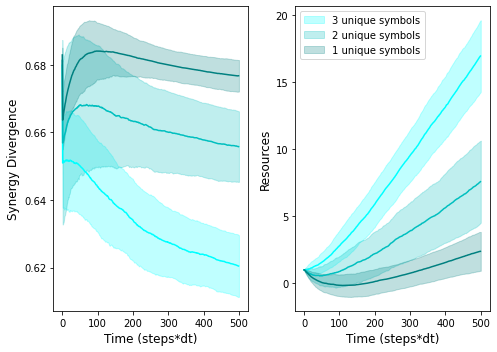

In [1367]:
plotFig1(groups2,agents2,res2,"a4config")

In [1370]:
#ns=4
p_xor_arr=np.array([0.97127455, 0.61326879, 0.88347114, 0.97951488, 0.79720529,
       0.73007327, 0.58225905, 0.90275687, 0.62610736, 0.82720445,
       0.63838547, 0.69427743, 0.69150079, 0.59997907, 0.98047016,
       0.51006602])

COOP=True
learn=True
groupsMAX,agentsMAX,resMAX=simulateGamble()

For signal 0
For params 0.44952073875 0.4704279425
LL [2.042707297674084, 1.9590419115994018]
P 0.44952073875 0.4704279425
With approximate growth rates: 0.0036461227874022527 


For signal 1
For params 0.57293656875 0.5938437725
LL [2.042707297674084, 1.9590419115994013]
P 0.57293656875 0.5938437725
With approximate growth rates: 0.014416476307898305 


For signal 2
For params 0.57490682875 0.5958140325
LL [2.0427072976740837, 1.9590419115994022]
P 0.57490682875 0.5958140325
With approximate growth rates: 0.01508817255005427 


For signal 3
For params 0.5083024574999999 0.5292096612499999
LL [2.042707297674084, 1.9590419115994018]
P 0.5083024574999999 0.5292096612499999
With approximate growth rates: 0.0011412276034246313 


GROUPS: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [

/Users/kempj/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/kempj/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


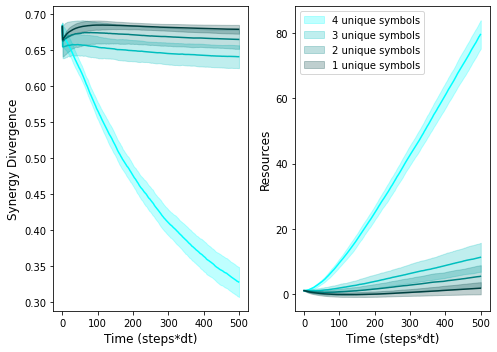

In [1376]:
plotFig1(groupsMAX,agentsMAX,resMAX,"a4configMAX2")

In [1460]:
xor_sltr

array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0])

In [1478]:
#ns=4
# p_xor_arr=np.array([.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8])
# p_xor_arr=np.array([.2,.8,.2,.8,.2,.8,.2,.8,.2,.8,.2,.8,.2,.8,.2,.8]) #Synergy requires ns-1 agents
p_xor_arr=np.array([.8,.2,.8,.2,.8,.2,.2,.8,.8,.2,.2,.8,.2,.8,.2,.8])
COOP=True
learn=True
groupsMAX,agentsMAX,resMAX=simulateGamble()
a4configMAX=computeGDKL(groupsMAX,agentsMAX,resMAX)

For signal 0
For params 0.35 0.65
LL [2.8571428571428568, 1.5384615384615388]
P 0.35 0.65
With approximate growth rates: 0.09285588124510916 


For signal 1
For params 0.35 0.65
LL [2.8571428571428568, 1.5384615384615388]
P 0.35 0.65
With approximate growth rates: 0.09285588124510916 


For signal 2
For params 0.35 0.65
LL [2.8571428571428568, 1.5384615384615388]
P 0.35 0.65
With approximate growth rates: 0.09285588124510916 


For signal 3
For params 0.35 0.65
LL [2.8571428571428568, 1.5384615384615388]
P 0.35 0.65
With approximate growth rates: 0.09285588124510916 


GROUPS: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71],

/Users/kempj/Library/Python/3.8/lib/python/site-packages/scipy/stats/_stats_py.py:307: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


In [1471]:
groups[250]

{'i': 250,
 'a': [377, 378, 379, 380],
 's': {0: 2, 1: 1, 2: 0, 3: 1},
 'x': [array([[0.57293593, 0.48954425, 0.53124009, 0.4478484 , 0.57293593,
          0.48954425, 0.53124009, 0.4478484 , 0.53124009, 0.4478484 ,
          0.48954425, 0.40615256, 0.53124009, 0.4478484 , 0.48954425,
          0.40615256],
         [0.42706407, 0.51045575, 0.46875991, 0.5521516 , 0.42706407,
          0.51045575, 0.46875991, 0.5521516 , 0.46875991, 0.5521516 ,
          0.51045575, 0.59384744, 0.46875991, 0.5521516 , 0.51045575,
          0.59384744]]),
  array([[0.57293593, 0.48954425, 0.53124009, 0.4478484 , 0.57293593,
          0.48954425, 0.53124009, 0.4478484 , 0.53124009, 0.4478484 ,
          0.48954425, 0.40615256, 0.53124009, 0.4478484 , 0.48954425,
          0.40615256],
         [0.42706407, 0.51045575, 0.46875991, 0.5521516 , 0.42706407,
          0.51045575, 0.46875991, 0.5521516 , 0.46875991, 0.5521516 ,
          0.51045575, 0.59384744, 0.46875991, 0.5521516 , 0.51045575,
          0.5

/Users/kempj/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/kempj/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


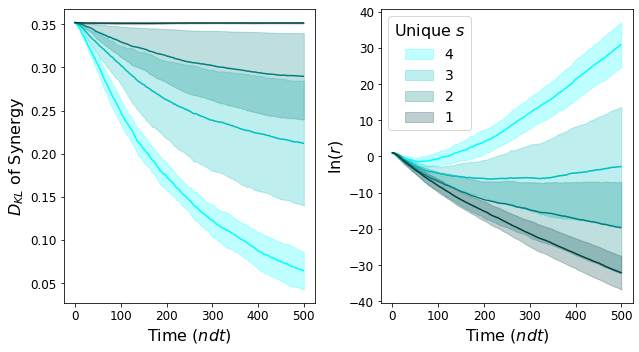

In [1479]:
plotFig1(a4configMAX,"a4configMAX34")

In [ ]:
#ns=3
p_xor_arr=np.array([0.9, 0.8, 0.7, 0.9, 0.8, 0.7,\
                   0.9, 0.8, 0.7,0.9, 0.8, 0.7,\
                   0.9, 0.8, 0.7,.9])

p_xor_arr=np.array([0.85, 0.65, 0.85, 0.65, 0.85,
       0.65, 0.85, 0.65, 0.85, 0.65,
       0.85, 0.65, 0.85, 0.65, 0.85,
       0.65])

In [ ]:
#TESTING CODE 1A
# test=np.reshape(signals,(20000,4))
# arr={i:[] for i in range(20)}
# for t in test:
#     a=np.multiply([4,2,1,1],t)
#     b=np.sum(a[:-1])
#     arr[b].append(a[-1])
# for key,value in arr.items():
#     plt.scatter(key,np.sum(value)/len(value))
#     print(bin(key)[2:],np.sum(value)/len(value))
# plt.show()

In [ ]:
# #TESTING CODE 2A
#     DKLS=[]
#     for g in groups.values():
#         dkl=np.zeros((steps,2))
#         for t in range(steps):
#             x=computeDKL(p_xor_arr,g['p'][t])

#             dkl[t]=x
#         DKLS.append(dkl)
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(12, 6)

#     for g,DKL in zip(groups.values(),DKLS):
#         if not COOP:
#             r=res[g['a'][0]]
#             plt.plot(np.log(r),color='k',alpha=.5)
#         else:
#             for a,iii in zip(g['a'],range(len(g['a']))):
#                 r=res[a]
#                 if iii==0:
#                     ax1.plot(np.log(r),color=g['c'],label=str(len(g['s_list']))+" Unique Signals")
#             ax2.plot(DKL,color=g['c'],label=str(len(g['s_list']))+" Unique Signals")
# #                 else:
# #                     plt.plot(np.log(r),color=g['c'])

#         GS.append(1/n*np.log(r[-1]/r[0]))
#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(),fontsize=12)
#     ax1.set_xlabel("STEPS",fontsize=12)
#     ax1.set_ylabel("RESOURCES",fontsize=12)
#     ax2.set_xlabel("STEPS",fontsize=12)
#     ax2.set_ylabel("SYNERGY DIVERGENCE",fontsize=12)
#     plt.show()
#     for a,g in zip(agents.values(),GS):
#         plt.scatter(a['gamma'],g)
#     plt.show()
#     plt.hist(pc)
#     plt.show()
#     counts,_,_x=plt.hist(pcc)
#     print(counts/np.sum(counts)*2)